#Preamble

This mini-project involves working through all the steps of a problem, whereas prior assignments asked you to just implement core functions. We will give you a dataset, but you will also have the opportunity to manipulate the data in ways that you find beneficial to the overall project and to explain why and how those manipulations mattered. This will be in addition to building the model from scratch, developing the training loop, and implementing testing. The code will be accompanied by a report written into the notebook.

This project will have you working with attention mechanism, in a new type of system for question-answering. This will provide you with experience working with attention mechanisms while not directly working with transformers.

This assignment is not autograded. You can modify any code cells as long as you achieve the requirements of each graded component.

# Introduction

Memory networks learn to access external memory stores (a database or, in the case of this assignment, a dictionary). Key-Value Memory Networks specifically assume that the external memory store is organized as a dictionary with keys and values. In theory memory networks are useful when one wants a neural network to be able to know a lot of information but we don't want to try to encode that information directly into the parameters of the network. This means information can be changed in the external memory database without retraining the neural network.

Given a question, e.g., "Where was Alexander Hamilton born?", a key-value memory network learns an embedding such that the question has a high cosine similarity to a particular key in the external dictionary. Because there are many keys that need to be matched against, key-value memory networks implement an attention-scoring mechanism to select a key. Because attention is a probabilistic score, the key-value memory network retrieves a sum of embeddings weighted according to the attention score. This weighted embedding is then compared to values using a second attention-scoring mechanism. The value with the highest cosine similarity can then be retrieved and returned as the answer.

Memory networks were an important part of the evolution of question-answering systems that have been eclipsed by transformers. However, the attention mechanism in a key-value memory network is very similar to the self-attention inside a transformer, so implementing a key-value memory network is a really great way to experiment and learn about self-attention without the added complexity of transformers.

Key-value memory networks are also closely related to retieval-based generation networks, except we will be retrieving facts from a dictionary instead of via the internet. However, the embedding of retrieved data will be similar.

Key-value memory networks are described in this [paper](https://arxiv.org/abs/1606.03126). It is recommended that you read the paper, but we will also walk through the steps you will need to complete.

# Some imports



You may add imports as necessary.

In [339]:
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import re
import os
import json
import random
import numpy as np
import pickle
from tqdm import tqdm
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt

In [340]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

Unidecode is useful for getting rid of issues that arise from unicode. This should not be used if we care about unicode, but for the purposes of an instructional exercise, it eliminates a lot of edge cases that come up with unicode.

In [341]:
!pip install unidecode

In [342]:
import unidecode

If you need to have a reduced vocabulary, you can create an unknown "unk" token and add it to the vocabulary. Make sure the token index in the vocabulary and `UNK_ID` match.

In [343]:
UNK = 'unk'
UNK_ID = '0'

# Some utilities

You may edit these as necessary.

Stem words

In [344]:
# Stemming the text
def simple_stemmer(text):
    ps=nltk.porter.PorterStemmer()
    text= [ps.stem(word) for word in text]
    return text

Simple tokenizer that only keeps letters and numbers.

In [345]:
def tokenize(line):
    line = re.sub(r'[^a-zA-Z0-9]', ' ', unidecode.unidecode(line)) # remove punctuation
    line = line.lower().split()  # lower case
    return line

A standard vocabulary object class

In [346]:
class Vocab:
    def __init__(self, name = 'vocab'):
        self.name = name
        self._word2index = {}
        self._word2count = {}
        self._index2word = {}
        self._n_words = 0

    def get_words(self):
      return list(self._word2count.keys())

    def num_words(self):
      return self._n_words

    def word2index(self, word):
      return self._word2index[word]

    def index2word(self, word):
      return self._index2word[word]

    def word2count(self, word):
      return self._word2count[word]

    def add_sentence(self, sentence):
        for word in tokenize(sentence):
            self.add_word(word)

    def add_word(self, word):
        if word not in self._word2index:
            self._word2index[word] = self._n_words
            self._word2count[word] = 1
            self._index2word[self._n_words] = word
            self._n_words += 1
        else:
            self._word2count[word] += 1

Make a bag of words frmo a sentence, given a vocabulary. Can return a bag of word counts or a a bag of word presences.

In [347]:
# ORIGINAL
# def multihot(s, vocab, preserve_counts = False):
#   tokens = np.array([vocab.word2index(t) for t in tokenize(s)])
#   mhot = np.zeros((tokens.size, vocab.num_words()))
#   mhot[np.arange(tokens.size), tokens] = 1
#   if preserve_counts:
#     return mhot.sum(0)
#   else:
#     return mhot.sum(0) >= 1

# Recreate multihot to add UNK
def multihot(s, vocab, preserve_counts = False):
    # tokenize
    tokens = tokenize(s)

    # Convert to indices but replace out vocab word with unk
    token_indices = []
    for token in tokens:
        if token in vocab._word2index:
           token_indices.append(vocab._word2index[token])
        else:         # token not in vocab
            if UNK in vocab._word2index:
                token_indices.append(vocab._word2index[UNK])

    # Create vector
    token_indices = np.array(token_indices)
    # Switch to 1d just easier to understand
    mhot = np.zeros(vocab.num_words())
    unique_indices, counts = np.unique(token_indices, return_counts=True)
    if preserve_counts:
        mhot[unique_indices] = counts
    else:
        mhot[unique_indices] = 1

    return mhot

If you have a reduced vocabulary, use this to replace out-of-vocab words. If you use this, you may want to merge it with `multihot` above to avoid tokenizing twice.

In [348]:
def unkit(s, vocab):
  return ' '.join(list(map(lambda x: UNK if x not in vocab._word2index else x, tokenize(s))))

# Part A: Download and Process Data (0 points)

This dataset contains the information in tables that are commonly used in Wikipedia biography pages. Each person has different rows of information pertaining to their notable accomplishments and details about their life. There are a large number of types of information that can appear as rows in the biography tables, however they are relatively uniform. We call the keys of the rows "relations".

For example [Alexander Hamilton](https://en.wikipedia.org/wiki/Alexander_Hamilton) has information about the President he worked for as Secretary of State, birth date, date of death, parents' names, etc.

The code below will download the dataset and process it to create two things:
- `DB`: a hash table that map titles of biography wikipedia articles to table information. The table information is represented as a nested hash table containing relations as keys, and associated values. For example, `DB['alexander hamilton'] = {'party': 'federalist',
 'spouse': 'elizabeth schuyler', ...}`
- `VOCAB`: A vocabulary object that maps words to tokens and vice versa.

In [349]:
!git clone https://github.com/rlebret/wikipedia-biography-dataset.git

fatal: destination path 'wikipedia-biography-dataset' already exists and is not an empty directory.


In [350]:
!copy /b wikipedia-biography-dataset\wikipedia-biography-dataset.z* tmp.zip
!dir tmp.zip
import zipfile
with zipfile.ZipFile('tmp.zip', 'r') as zip_ref:
    zip_ref.extractall('.')  
print("Extraction complete!")

wikipedia-biography-dataset\wikipedia-biography-dataset.z00
wikipedia-biography-dataset\wikipedia-biography-dataset.z01
wikipedia-biography-dataset\wikipedia-biography-dataset.z02
wikipedia-biography-dataset\wikipedia-biography-dataset.z03
wikipedia-biography-dataset\wikipedia-biography-dataset.z04
wikipedia-biography-dataset\wikipedia-biography-dataset.z05
wikipedia-biography-dataset\wikipedia-biography-dataset.z06
wikipedia-biography-dataset\wikipedia-biography-dataset.z07
wikipedia-biography-dataset\wikipedia-biography-dataset.z08
wikipedia-biography-dataset\wikipedia-biography-dataset.z09
wikipedia-biography-dataset\wikipedia-biography-dataset.z10
wikipedia-biography-dataset\wikipedia-biography-dataset.z11
wikipedia-biography-dataset\wikipedia-biography-dataset.z12
wikipedia-biography-dataset\wikipedia-biography-dataset.z13
wikipedia-biography-dataset\wikipedia-biography-dataset.z14
wikipedia-biography-dataset\wikipedia-biography-dataset.z15
        1 file(s) copied.
 Volume in dri

Get all the wikipedia titles.

In [351]:
train_titles = []
with open("wikipedia-biography-dataset/train/train.title", "r", encoding="utf-8") as file:
  for line in file:
    train_titles.append(line.rstrip())
print(len(train_titles))

582659


Boxes contain all the information, with each line corresponding to a title in `titles`.

In [352]:
train_boxes = []
with open("wikipedia-biography-dataset/train/train.box", "r") as file:
  for line in file:
    train_boxes.append(line.rstrip())
print(len(train_boxes))

582659


This will make the DB object, a dictionary of dictionaries for each wikipedia title, which is more or less the same as names. This function only keeps politicians (containing the "office" key term) and strips out information about images. It can be improved in many ways.

In [353]:
# Make a dictionary of dictionaries
def make_db(titles, boxes):
  db = {} # The DB
  # Iterate through titles
  for i in tqdm(range(len(titles))):
    box = boxes[i] # Grab the corresponding box information
    d  = {} # Inner dictionary
    # Build a dict for the ith entry
    # grab each key:value pair
    for pair in re.findall(r'([a-zA-Z_]+)[0-9]*\:([\w\d]+)', box):
      key, value = pair
      # Do a bit of cleaning
      key = key.strip()
      value = value.strip()
      # If the key contains the word image, we probably don't want to keep it
      if 'image' not in key:
        # The regex maintains underscores, strip those off
        if key[-1] == '_':
          key = key[:-1]
        # Make a new entry in inner dictionary if we don't have one
        if key not in d:
          d[key] = value
        # Keys with compound values are split up, which is annoying, so put them back together
        else:
          d[key] += ' ' + value
    # If it has an office key, keep it.
    if 'office' in d:
      db[titles[i]] = d
  return db

Build the vocab from the DB. Convert the whole thing into a string, tokenize it, and feed the surviving words into the vocab.

In [354]:
def make_vocab(DB):
  # Make the vocab object
  vocab = Vocab()
  # Tokenize the data by converting the entire DB into a string
  tokens = tokenize(str(DB))
  # Iterate through all the tokens (tqdm provides a progress bar)
  for t in tqdm(tokens):
    vocab.add_word(t)
  print("make vocab ",vocab.num_words())
  return vocab

If you want to discard rare words, this will rebuild the vocab. This is just an example.

In [355]:
def reduce_vocab(vocab, min_word_occurrence = 2):
  # make a new vocab
  vocab2 = Vocab("top")
  # Add the UNK token
  vocab2.add_word(UNK)
  # Iterate through vocabulary
  for w in list(vocab._word2count.keys()):
    count = vocab._word2count[w]
    idx = vocab._word2index[w]
    # If the word count passes threshold, add it to the new vocabulary object
    if count >= min_word_occurrence:
      vocab2.add_word(w)
      vocab2._word2count[w] = count
  # Return the new vocabulary object
  return vocab2

Make the DB

In [356]:
DB = make_db(train_titles, train_boxes)

100%|██████████| 582659/582659 [00:32<00:00, 18166.59it/s]


Make the VOCAB

In [378]:
VOCAB = make_vocab(DB)
print(VOCAB.num_words())

# Modify to reduce vocab.
reduced_vocab = reduce_vocab(VOCAB, min_word_occurrence = 3)
print("Original vocab size ",VOCAB.num_words())
print("Reduced vocab size ", reduced_vocab.num_words())

VOCAB = reduced_vocab

100%|██████████| 2997937/2997937 [00:01<00:00, 2099087.99it/s]

make vocab  96093
96093
Original vocab size  96093
Reduced vocab size  47085


## Save Processed Data

You may find it useful to save the processed dataset to your Google Drive.

It is recommended that you save the file to your Google Drive. To mount your Google Drive, open the file icon on the left side of the screen to get to the option). To save the file in your Google Drive use the path `'drive/MyDrive/filename'`.)

In [379]:
# from google.colab import drive
# drive.mount('/content/drive')

In [380]:
# with open("drive/MyDrive/data", "wb") as f:
#   pickle.dump(DB, f, protocol=None, fix_imports=True, buffer_callback=None)

In [381]:
# with open('drive/MyDrive/vocab', 'wb') as f:
#     pickle.dump(VOCAB, f, protocol=None, fix_imports=True, buffer_callback=None)

In [393]:
os.makedirs("saveddata", exist_ok=True)

# Save DB
with open("saveddata/DB.pkl", "wb") as f:
    pickle.dump(DB, f)

# Save VOCAB
with open("saveddata/VOCAB.pkl", "wb") as f:
    pickle.dump(VOCAB, f)

## Load processed data

If you have saved the processed data in your Google Drive, you can re-load it with these commands.

In [394]:
# with open("drive/MyDrive/vocab", "rb") as f:
#   VOCAB = pickle.load(f)

In [395]:
# with open("drive/MyDrive/data", "rb") as f:
#   DB = pickle.load(f)

In [396]:
# Load VOCAB
with open("saveddata/VOCAB.pkl", "rb") as f:
    VOCAB = pickle.load(f)

# Load DB
with open("saveddata/DB.pkl", "rb") as f:
    DB = pickle.load(f)

## Data example

Get to know your data.

In [397]:
DB["alexander hamilton"]

{'name': 'alexander hamilton',
 'office': '1st united states secretary of the treasury senior officer of the army delegate to the congress of the confederation from new york',
 'president': 'george washington john adams',
 'term_start': 'september 11 1789 december 14 1799 november 3 1788 november 4 1782',
 'term_end': 'january 31 1795 june 15 1800 march 2 1789 june 21 1783',
 'predecessor': 'position established george washington egbert benson seat established',
 'successor': 'oliver wolcott jr james wilkinson seat abolished seat abolished',
 'birth_date': '11 january 1755',
 'birth_place': 'charlestown nevis british west indies',
 'death_date': 'july 12 1804 aged 47 or 49',
 'death_place': 'new york city new york u',
 'party': 'federalist',
 'spouse': 'elizabeth schuyler',
 'children': 'philip angelica alexander james alexander john church william stephen eliza holly phil',
 'alma_mater': 'kings college new york',
 'religion': 'presbyterian episcopalian convert',
 'signature': 'alexan

# Part B: Implement the Key-Value Memory Network (10 points)

This [paper](https://arxiv.org/abs/1606.03126) describes the key-value memory networks in detail, which is also sketched out below.

A key-value memory network takes a natural language question. This question will be converted into a bag-of-words (i.e., a multihot) Call this $x$ and it is a 1D tensor of vocabulary length.

![KVMemNet architecture](https://github.com/markriedl/kvmemnet-assignment/blob/32479dd1e88a9f8dfc72f11ccb8e9e0e1f78905f/kvmemnet-inside.png?raw=true)

The KVMemNet will contain a linear layer (or embedding layer) that will produce a 1D embedding of the question $q=A(x)$.

The KVMemNet will also take in a stack of keys as a tensor of shape `num_keys x vocab_size`. Each row is embedded using the same embedding, $k=A(keys)$, producing a tensor of shape `num_keys x embed_dim`. How this stack of keys is chosen will be discussed below.

The KVMemNet will take in a third input, a stack of values associated with the stack of keys. This will also be of shape `num_values x vocab_size`. Each row is embedded using the same embedding, $v=A(values)$, producing a tensor of shape `num_keys x embed_dim`.

The KVMemNet will also contain a second linear embedding layer, $B$. More on this later.

Once we have `q`, `k`, and `v` embeddings, the next step is to use `q` and `k` to compute attention scores that can be applied against `v`. Think of $A$ as learning how to make questions and the keys that should match against values that have received the same treatment.

The attention scores `p` are computed by taking the inner-product (`torch.inner()`) between `q` and `k`. The result will be a 1D tensor with `num_keys` length. Use softmax so that `p` contains scores between 1.0 and 0.0.

You may be wondering why there isn't a non-linearity such as a sigmoid or ReLU after the linear layer. Softmax is a non-linearity.

Next apply the `p` attention scores against `v` to apply a weight against each value in the stack of values. One should be highly weighted and the rest less weighted. Sum all the weighted values up to create a 1D tensor `o` of feature weights of length `embed_dim`. `p` can be thought of as how much of each value gets selected. Then they all get combined together and the feature weights are proportional to how much each value was attended to. The `torch.matmul()` can do the multiplication and summing in one step.

The KVMemNet forward function should return this tensor of feature weights `o`.

A quick note on `k` and `v`. We can't send the entire set of keys and values in our database through the network's forward function. Instead there should be a selection mechanism that selects just a subset of the database. This subset should contain the best key for the question $x$ to match against, and its corresponding value. We assume that a shallow selection process can narrow down the key-value pairs to a relatively small set, one of which will be best. For example, if the question involves "Alexander Hamilton", we can reasonably guess that the best key-value pair is in the part of the database associated with the named person.

We are not done though. What about our linear layer $B$? Suppose variable `Y` contains our entire set of values in our databse as bags of words. $B$ is going to be used to embed our entire set of database values $y=B(Y)$. $B$ can be thought of as learning how to make all the values look like the feature weights output by the model such that the highest cosine similarity corresponds to the correct value taken from *all* values in the database.

$B$ should live inside the KVMemNet object so that its parameters become trainable, but notice that we do not use $B$ in the KVMemNet's forward function. $B$ will get used to prepare the stack of all values in the database for training. It will bet used in the training loop but outside of the forward function. This is a bit unusual, but necessary to figure out the correct target (the true index of the best value to match against) for training.

The above explantion only implements *single-hop* retrieval. *multi-hop* retrieval allows the results of one retrieval to inform a second (and third and so on) to get the right retrieval. This would be used in the case where the answer cannot be inferred directly from the question in a single retrieval, such as "What was the founding date of the country that Alexander Hamilton was born in?". To implement multi-hop retrieval, the KVMemNet will have additional linear layers $R_1...R_n$. Each $R_{i}$ will do a linear transform on `q` then attention will score and retrieve values as feature weights `o`. This will be sent to the next $R_{i+1}$ and so on until the hops are complete. This final `o` will be returned.

For this assignment is is sufficient to only do *single-hop* retrieval.

The above explanation does not include consideration of batching. You may want to add a batch dimension as the first dimension and input a batch as a set of questions, a set of stacks of keys, and a set of stacks of values. To do this, functions like `.inner()`, `.mm()`, and`.matmul()` will not work. Instead use `.bmm()` which handles batching correctly. You will probably need to do some `.squeeze()` and `.unsqueeze()` operations to make sure your tensors are the correct shapes.

Instead of bag-of-words, one may also consider first converting each question, key, and value into a general set of embeddings such as [GLoVe](https://nlp.stanford.edu/projects/glove/). To do this one will need to consider how to combine words--convert each word into an embedding vector and then add the vectors together (or maybe average them).

**Complete the key-value memory net code**

In [398]:
class KVMemNet(nn.Module):
  def __init__(self, vocab_size, embed_dim):
    super(KVMemNet, self).__init__()
    self.vocab_size = vocab_size
    self.embed_dim = embed_dim
    
    # Embedding layer A: shared for questions and keys
    self.A = nn.Linear(vocab_size, embed_dim)
    
    # Embedding layer B: for database values (used in training loop)
    self.B = nn.Linear(vocab_size, embed_dim)

  def forward(self, x, keys, values):
    # print("x shape",x.shape)
    # print("keys shape", keys.shape)
    # print("value shape", values.shape)
    
    # Handle different dimensdion intead of batch_size
    if x.dim() == 1:
      x = x.unsqueeze(0)                  # shape (1,vocab_sz)
      keys = keys.unsqueeze(0)            # shape (1,num_keys, vocab_size)
      values = values.unsqueeze(0)        # shape (1, num_keys, vocab_size)

    # Embedding q,k,v
    q = self.A(x)                         # (batch_size, embed_dim)
    k = self.A(keys)                      # (batch_size, num_keys, embed_dim)
    v = self.A(values)                    # (batch_size, num_keys, embed_dim)

    # Modify querry
    q = q.unsqueeze(1)                    # (batch_size, 1, embed_dim)
    # k.transpose(1,2) shape (batch_size, embed_dim, num_keys)
    attentions_matrix = torch.bmm(q, k.transpose(1,2))             # (batch_size, 1, num_keys)
    attention_probability = F.softmax(attentions_matrix, dim = 2)      # (batch_size, 1, num_keys)


    output = torch.bmm(attention_probability,v)         # (batch_size, 1, embed_dim)
    # print("o",output.shape)
    output = output.squeeze(1)                      # (batch_size, embed_dim)


    
    return output


# Synthetic Data Set

This is a synthetic dataset. One way to test a model during development is to take a small piece of data and show that you can overfit a model. If you can't overfit an easily learned chunk of data, then you probably have something wrong in your code. In this case I have provided a small chunk of synthetic data that should be easy to learn.

- The vocabulary is 20 word: 5 names, 5 relations, 5 question-words, 5 values
 - First 5 elements of the vocab are names (for example index 0 might be "Hamilton").
 - Second 5 elements of the vocab are relations (for example, "born", "died", "occupation").
 - Third 5 elements are random words that might be part of a query (for example, "When was").
 - Final 5 elements of the vocab are possible values (for example, "1757")
- A "question" is a name (5, 1), relation (5, 1), some words (5, 1), and no values
- The keys will all have the same name (5, 5) where each row is idential, relations (5, 5), no words, no values
- Values will have no names, no relations, no words, and value vocab words

In [399]:
# Turn on a different relation on each row
relations = torch.zeros(5, 5)
relations.fill_diagonal_(1)

# training data
train_data = {}
for i in range(5):
  # Name associated with questions, keys, values
  train_data[i] = (torch.cat([F.one_hot(torch.arange(0, 5))[i].repeat(5, 1),
                         relations,
                         torch.randint(0, 2, (5, 5)).float(),
                         torch.zeros(5, 5)], dim=1),
              torch.cat([F.one_hot(torch.arange(0, 5))[i].repeat(5, 1),
                         relations,
                         torch.zeros(5, 5),
                         torch.zeros(5, 5)], dim=1),
              torch.cat([torch.zeros(5, 5),
                         torch.zeros(5, 5),
                         torch.zeros(5, 5),
                         torch.randint(0, 2, (5, 5)).float()], dim=1))
  Y = torch.cat([v[2] for v in list(train_data.values())], dim=0).to('cuda')

In [400]:
# VERIFY synthetic data shape
train_data[1]
for k, v in train_data.items():
    print(f"Key: {k}")
    for i, tensor in enumerate(v):
        print(f"Tensor {i} shape: {tensor.shape}")

Key: 0
Tensor 0 shape: torch.Size([5, 20])
Tensor 1 shape: torch.Size([5, 20])
Tensor 2 shape: torch.Size([5, 20])
Key: 1
Tensor 0 shape: torch.Size([5, 20])
Tensor 1 shape: torch.Size([5, 20])
Tensor 2 shape: torch.Size([5, 20])
Key: 2
Tensor 0 shape: torch.Size([5, 20])
Tensor 1 shape: torch.Size([5, 20])
Tensor 2 shape: torch.Size([5, 20])
Key: 3
Tensor 0 shape: torch.Size([5, 20])
Tensor 1 shape: torch.Size([5, 20])
Tensor 2 shape: torch.Size([5, 20])
Key: 4
Tensor 0 shape: torch.Size([5, 20])
Tensor 1 shape: torch.Size([5, 20])
Tensor 2 shape: torch.Size([5, 20])


# Part C: Train on Synthetic Data (5 points)

The following describes the steps to set up a training loop, including the training of the $B$ layer.

![The KVMemNet being used in the training loop](https://github.com/markriedl/kvmemnet-assignment/blob/main/kvmemnet-outside.png?raw=true)

- Create a model with the given vocabulary size and an embedding size that is equal to or smaller.
- Loop through `N` epochs:
 - There are five names, loop through each name.
   - Get a stack of questions, stack of keys, and stack of values from `DB_synth`.
   - Loop through the relations. There is relation on each row of the keys and values.
     - Get a single question, the `i`-th row in the questions pulled from `DB_synth` above.
     - Compute the target: this is the `name*5 + i` element in `Y`.
     - Run the singular question, stack of keys, and stack of values through the model and produce an output, which is a tensor of feature weights.
     - Run all of `Y` through `model.B()` to get an embedded stack of values.
     - Take the softmax of the inner product between the embedded stack of values from `Y` and the feature weight generated by the model.
     - Compute the loss with `nn.CrossEntropyLoss`.
     - Call `.backward()` on the loss.

In addition to printing the loss (after every question or after every name in `DB_synth`) you can also print the target and the argmax of the softmax result to see if they match. Over time you should see the target and the argmax in agreement. For the purposes of this part of the project it is sufficient to test on the training set.

Don't forget to move the model and the tensor to the GPU.

You may want to speed up training by implementing batching. To do this, the model `forward()` needs to take tensors with an extra batching dimension as the first dimension. However, `.inner()`, `.mm()`, and `.matmul()` will not work properly. You will need to use `.bmm()` instead, which understands the first dimension is for batching. You will likely find that you need to perform some `.squeeze()` and `.unsqueeze()` operations. You can try batch-size of one, or take entire chunks (or even all synthetic data as a single, large batch). Try it different ways.

Try training on the synthetic data first.

You may make as many cells as necessary. Save your notebook outputs that plot loss and show it reducing.

**Write code blocks below that create the `KVMemNet`**

In [407]:
# Set up your KVMemNet, move it to the GPU, setup up optimizer (e.g., Adam), and criterion.

# Init parameters
vocab_size = 20  
embed_dim = 5   # Embedding dimension
num_names = 5
num_relations = 5

# Create the Key-Value Memory Network
model = KVMemNet(vocab_size, embed_dim)
model = model.to(device)

# Set up optimizer (Adam)
optimizer = optim.Adam(model.parameters(), lr=0.0008)

# Set up loss criterion - CrossEntropyLoss
criterion = nn.CrossEntropyLoss()

**Write and run a training testing loop. Show that your training loop loss converges with a plot**

To plot a loss curve, compute the mean loss per epoch and save it in a list:
```
x_axis.append(epoch_number)
y_axis.append(mean_epoch_loss_for_this_epoch)
plt.plot(x_axis, y_axis)
plt.show()
```

In [408]:
# Write your training loop here
# We stick to the picture above to set up part C

x_axis, y_axis = [], []
# Set up epoch
epochs= 500

# Iterate
for epoch in range(epochs):
    # Init record keeping
    loss_count = 0
    total_count = 0
    correct_count = 0

    # Loop over names and extract train data
    for name_id in range(num_names):
        questions, keys, values = train_data[name_id]
        questions = questions.to(device)
        keys = keys.to(device)
        values = values.to(device)

        # Loop over relations
        for relation_index in range(num_relations):
            q = questions[relation_index].clone()          # (20)
            k = keys.clone()                                # (5,20)
            v = values.clone()                              # (5,20)
            # print("q",q.shape)
            # print("k",k.shape)
            # print("v",v.shape)

            # Run forward pass
            output = model(q, k, v)  # (1, embed_dim)
            # print(output.shape)

            # Embed all possible values using B
            y_embed = model.B(Y)  # (25, embed_dim)

            # Compute similarity and loss
            pred_probability = torch.matmul(output, y_embed.T)  # (1, 25)
            target = torch.tensor([name_id * num_relations + relation_index], dtype=torch.long).to(device)
            # print(target.shape)

            # Back Propagation
            loss = criterion(pred_probability, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Increment recording tracking
            loss_count += loss.item()
            total_count += 1
            pred = torch.argmax(pred_probability, dim=1).item()
            # print("Target: ",target.item())
            # print("Pred: ", pred)
            correct_count += int(pred == target.item())
    
    accuracy = correct_count / total_count
    avg_loss = loss_count / total_count
    x_axis.append(epoch)
    y_axis.append(avg_loss)
    print(f"Epoch {epoch+1:>2}  average loss = {avg_loss:.4f} accuracy = {accuracy:.2%}")


Epoch  1  average loss = 3.2179 accuracy = 4.00%
Epoch  2  average loss = 3.2159 accuracy = 4.00%
Epoch  3  average loss = 3.2148 accuracy = 4.00%
Epoch  4  average loss = 3.2137 accuracy = 4.00%
Epoch  5  average loss = 3.2126 accuracy = 4.00%
Epoch  6  average loss = 3.2114 accuracy = 4.00%
Epoch  7  average loss = 3.2102 accuracy = 4.00%
Epoch  8  average loss = 3.2090 accuracy = 4.00%
Epoch  9  average loss = 3.2076 accuracy = 4.00%
Epoch 10  average loss = 3.2062 accuracy = 4.00%
Epoch 11  average loss = 3.2047 accuracy = 4.00%
Epoch 12  average loss = 3.2031 accuracy = 4.00%
Epoch 13  average loss = 3.2014 accuracy = 8.00%
Epoch 14  average loss = 3.1995 accuracy = 8.00%
Epoch 15  average loss = 3.1975 accuracy = 8.00%
Epoch 16  average loss = 3.1953 accuracy = 8.00%
Epoch 17  average loss = 3.1928 accuracy = 8.00%
Epoch 18  average loss = 3.1901 accuracy = 8.00%
Epoch 19  average loss = 3.1871 accuracy = 8.00%
Epoch 20  average loss = 3.1838 accuracy = 8.00%
Epoch 21  average lo

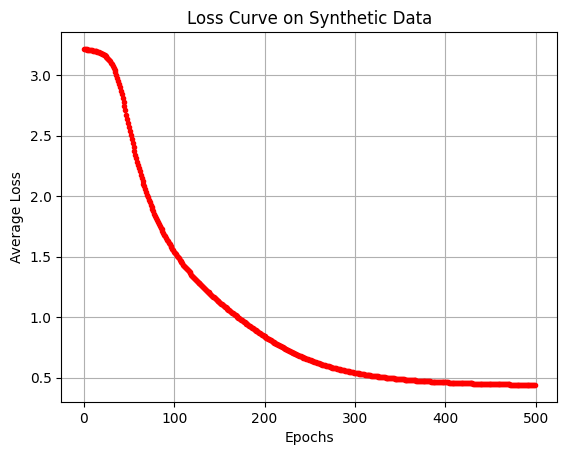

In [409]:
# Plot loss curve
plt.plot(x_axis, y_axis, marker='o', color ='red', markersize = 3)
plt.title("Loss Curve on Synthetic Data")
plt.xlabel("Epochs")
plt.ylabel("Average Loss")
plt.grid(True)
plt.show()

# Part D: Training on the Full Data (10 points)

To train on the full data, you are going to need to do some pre-processing of the data.

First, there are no "questions". You need to generate questions for each type of relation. There a number of ways to do this. The simplest is to just assume that a question is the name of a person and a relation, e.g., "Alexander Hamilton birth date". Another way would be to create templates for each type of relation. For example the "birth date" relation would have the following template: "When was [name] born?", filling in the [name]. Because there are a lot of different types of relations, you may want to remove the more obscure relations so you need fewer templates and also have a smaller vocabulary. Templates work well if the questions are expected to be almost identical to the templates. You may want to generate multiple templates per relation. Continuing the previous example, a second template would be: "What is the birthdate of [name]?".

If you are feeling more ambitious, you could use GPT-J, GPT-NeoX, GPT-3 or ChatGPT to generate templates. It works decently well and you can get some variety of templates.

The question should contain information about the person and some words that are representative of the relation even if the exact relation words aren't used (the KVMemNet should figure out that "birthdate" and "born" are correlated).

You only put a subset of all key-value pairs into the KVMemNet. You need a technique for sub-selecting from all the key-value pairs in `DB`. You might just need the ones that are directly associated with the person (Alexander Hamilton has 23). You may need to mix in a few key-value pairs from another person's entries in the database to help ensure against accidental overfitting.

The final challenge you will have in the training loop is that there may still be too many unique values in `Y` to encode and create one big tensor. In that case, you can at least use the values that you sent to the KVMemNet, along with as many other randomly selected values as you can fit into the GPU's memory.

Create as many cells below as you need. Save the output of your training and testing functions, reporting loss during training and accuracy during testing. 5 points for a training loop that reduces loss. 5 points for a training function with a correct accuracy computation.

**Create a training dataset and a non-overlapping testing dataset**

If CPU memory becomes a problem you might want to consider a `DataLoader` so that data can be stored on file and pulled up when needed.

In [456]:
# Create your training and test sets here


# Get people from DB
people_list = list(DB.keys())
print("people list ",len(people_list))

# Split into train and test sets
random.shuffle(people_list)
train_indices = int(0.8 * len(people_list))
people_train = people_list[:train_indices]
people_test = people_list[train_indices:]
print("Training : ", len(people_train))
print("Testing: ", len(people_test))

# Pick some relations based on the DB
sample_relations = [
    'birth_date', 'birth_place', 'death_date', 'death_place', 
    'office', 'party', 'spouse', 'children', 'religion'
]

# Function to create the dataset
def create_dataset(people_list, max_samples=None):
    # Dataset (question, key, value)
    dataset = []
    
    # Loop through person list
    for person in people_list:
        person_data = DB[person]
        
        # Loop through each relation we want to use to create questions
        for relation, value in person_data.items():
            if relation in sample_relations:
                # Create simple questions based on suggestion in the notes
                # Question: person + relation (like "alexander hamilton birth_date")
                question = f"{person} {relation}"
                
                # Key use to match value so set up name + relations, aka same as questions
                key = question
                # key = person
                
                # Value:
                dataset.append((question, key, value))
                
                # Set up max_samples to limit the amount of data we will train later
                if max_samples and len(dataset) >= max_samples:
                    break
        
        if max_samples and len(dataset) >= max_samples:
            break
    return dataset

# Create train and set data process
train_data = create_dataset(people_train, max_samples=8000)  
print("Training data: ", len(train_data))
test_data = create_dataset(people_test, max_samples=2000) 
print("Test data: ", len(test_data))

# Collect all unique values for the Y matrix
all_values = []
for _, _, value in train_data + test_data:
    all_values.append(value)

print("Total unique values: ", len(all_values))


print(f"Question: {train_data[10][0]}")
print(f"Target: {train_data[10][2]}")

people list  40786
Training :  32628
Testing:  8158
Training data:  8000
Test data:  2000
Total unique values:  10000
Question: abdur rab nishtar birth_date
Target: yes 1899 06 13


**Create your `KVMemNet`**

In [457]:
# Set up your KVMemNet here

vocab_size = VOCAB.num_words()
embed_dim = 128  

# Create the model for full dataset
model = KVMemNet(vocab_size, embed_dim)
model = model.to(device)

# Set up optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Loss criterion
criterion = nn.CrossEntropyLoss()

**Write and run a training loop, showing a loss plot**

You may find it handy to also test your network on the test data periodically as it trains.

In [458]:
# Training loop goes here
from torch.optim.lr_scheduler import StepLR

# Implement batch data processing first, return list of batches of data
def split_data_to_batches(full_data, batch_size = 16):
    batches = []
    for i in range(0, len(full_data), batch_size):
        batch = full_data[i:i + batch_size]
        batches.append(batch)

    return batches

# Implement batch data processing step
# Tokenize, convert to multihot
# convert to tensor, set up target
# From partB, we need question, key, value data plus the target for loss calculation
def batch_data_processing(batch_data, vocab, max_key = 30):
    # The main idea in batch data is that even though we have correct question,key,value.
    # We want to introduce random distractor to make the learning harder.
    # For simplicity we will stack the correct key,value answer to first index

    # Init records
    processed_questions = []
    batch_keys = []
    batch_values = []
    processed_targets = []

    # Loop through the batch data
    for question, key, value in batch_data:
        question = multihot(question,vocab, preserve_counts=True)
        processed_questions.append(torch.FloatTensor(question))

        # Here on key,value stacks we put correct answer on top index
        keys_stack = [key]
        values_stack = [value]

        # Next we need to generate extra random values
        additional_samples = random.sample(train_data, max_key-1)
        for _, additional_key, additional_value in additional_samples:
            if len(keys_stack) >= max_key:      # in case overflow data
                break
            # append extra key,value
            keys_stack.append(additional_key)
            values_stack.append(additional_value)

        # BOW
        keys_bow = []
        values_bow = []
        for k, v in zip(keys_stack,values_stack):
            k_bow = multihot(k, vocab, preserve_counts= True)
            v_bow = multihot(v, vocab, preserve_counts=True)
            keys_bow.append(torch.FloatTensor(k_bow))
            values_bow.append(torch.FloatTensor(v_bow))

        # Append keys and values to processed batch
        batch_keys.append(torch.stack(keys_bow))
        batch_values.append(torch.stack(values_bow))

        processed_targets.append(0)         # correct answer for all questions are in index 0

    # Stack batch tensor
    processed_questions = torch.stack(processed_questions)
    processed_keys = torch.stack(batch_keys)
    processed_values = torch.stack(batch_values)
    processed_targets = torch.LongTensor(processed_targets)

    return processed_questions, processed_keys, processed_values, processed_targets

### Training function folr 1 epoch
def train_epoch(model, train_data, optimizer, criterion, epoch_count):
    # Init
    model.train()
    total_loss = 0
    correct_count = 0
    total_count = 0

    # Create batches from train_data
    batches = split_data_to_batches(train_data, batch_size= 16)
    print(f"Training epoch {epoch_count} and batches {len(batches)}")
    for i, batch in enumerate(batches):
        
        # Processed data in batch, model we implement in B take separate q,k,v
        q,k,v, target = batch_data_processing(batch, VOCAB, max_key=30)         # Higher max key is more challenging and computational

        # Move to cuda
        # print(device)
        q = q.to(device)
        k = k.to(device)
        v = v.to(device)
        target = target.to(device)

        # Forward
        batch_output = model.forward(q,k,v)         # (batch_size, embed_dim)
        # print("batch output", batch_output.shape)

        # Similar to partC, need an embedding for all values in batch
        # Let it go through B, and bmm with the output like the figure in C
        values_flat = torch.flatten(v, start_dim=0, end_dim=1)      # flat (batch_size * max_keys, vocab_size)
        # print("value flat",values_flat.shape)
        embed_batch_value = model.B(values_flat)
        # Reshape back after flatten.
        embed_batch_value = torch.reshape(embed_batch_value, (v.size(0), v.size(1), -1))        # (batch, max_key, embed_dim)
        # print("embed_batch value", embed_batch_value.shape)

        # Using bmm to calculate scores/similarity
        # batch_output (batch_size, embed_dim)  ---> (batch, 1, embed)
        # embed_batch_value (batch, max_key, embed_dim) ---> (batch, embed, max_key)
        scores = torch.bmm(batch_output.unsqueeze(1), embed_batch_value.transpose(1,2)).squeeze(1)          # (batch, 1, max_key)

        # Loss
        loss = criterion(scores, target)

        # Back Propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Records keeping
        total_count += target.size(0)
        total_loss += loss.item()
        _, predict = torch.max(scores.data, 1)
        correct_count += (predict == target).sum().item()

        # Print progress
        if i % 100 == 0:
            batch_accuracy = (predict == target).sum().item() / target.size(0)
            print(f"Batch {i}/{len(batches)}, Loss: {loss.item():.4f}, Acc: {batch_accuracy:.2f}")

    avg_loss = total_loss/len(batches)
    accuracy = correct_count/total_count

    return avg_loss, accuracy

### Main

print("Training")
# Init records keeping for graph
train_losses = []
train_accuracy = []
epochs = 15

# Edit: 7.23 Add learning schedule so it learn faster from begining
# Reduce lr by 50% every 3 epoc
lr_schedule = StepLR(optimizer, step_size = 3, gamma = 0.5)

for epoch in range(epochs):

    # Train
    epoch_loss, epoch_acc = train_epoch(model, train_data, optimizer, criterion,epoch)

    # Edit 7.23 decay lr
    lr_schedule.step()

    # Record for graph later
    train_losses.append(epoch_loss)
    train_accuracy.append(epoch_acc)

    print(f"Epoch {epoch}/{epochs} - Loss: {epoch_loss:.2f}, Accuracy: {epoch_acc:.2f}")

          



Training
Training epoch 0 and batches 500
Batch 0/500, Loss: 3.4013, Acc: 0.00
Batch 100/500, Loss: 3.3957, Acc: 0.00
Batch 200/500, Loss: 3.3922, Acc: 0.19
Batch 300/500, Loss: 3.2936, Acc: 0.00
Batch 400/500, Loss: 3.0183, Acc: 0.06
Epoch 0/15 - Loss: 3.28, Accuracy: 0.05
Training epoch 1 and batches 500
Batch 0/500, Loss: 2.7666, Acc: 0.12
Batch 100/500, Loss: 3.4269, Acc: 0.00
Batch 200/500, Loss: 2.8860, Acc: 0.19
Batch 300/500, Loss: 3.0138, Acc: 0.00
Batch 400/500, Loss: 2.7059, Acc: 0.12
Epoch 1/15 - Loss: 2.84, Accuracy: 0.12
Training epoch 2 and batches 500
Batch 0/500, Loss: 2.2660, Acc: 0.38
Batch 100/500, Loss: 2.6340, Acc: 0.19
Batch 200/500, Loss: 2.1195, Acc: 0.44
Batch 300/500, Loss: 2.8243, Acc: 0.25
Batch 400/500, Loss: 1.7543, Acc: 0.62
Epoch 2/15 - Loss: 2.22, Accuracy: 0.31
Training epoch 3 and batches 500
Batch 0/500, Loss: 1.6278, Acc: 0.56
Batch 100/500, Loss: 2.0149, Acc: 0.38
Batch 200/500, Loss: 1.5723, Acc: 0.50
Batch 300/500, Loss: 1.6578, Acc: 0.56
Batch 

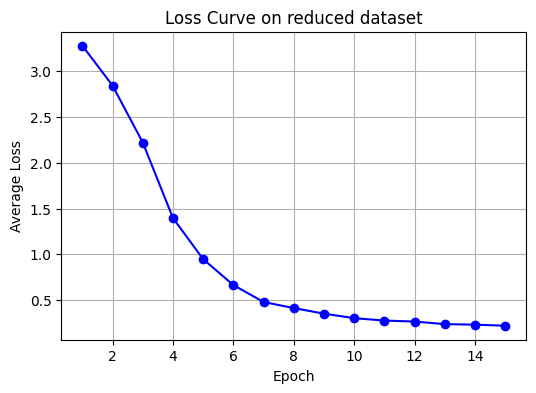

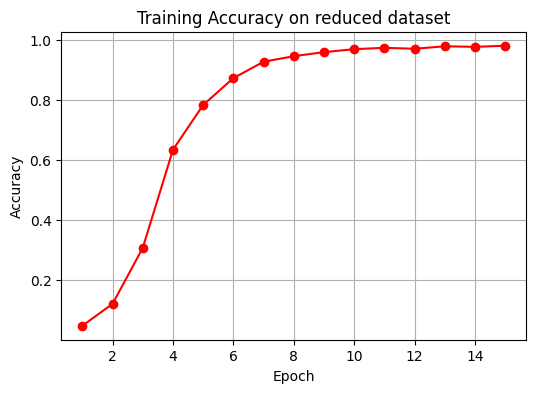

In [459]:
# Plot training loss
plt.figure(figsize=(6, 4))
plt.plot(range(1, len(train_losses) + 1), train_losses, 'b-', marker='o')
plt.title('Loss Curve on reduced dataset')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.grid(True)
plt.show()

# Plot training accuracy
plt.figure(figsize=(6, 4))
plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, 'r-', marker='o')
plt.title('Training Accuracy on reduced dataset')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

**Write the code for testing your model on the test data**

Your training loop can call the testing loop. But make sure that you do one last test on the model after training completes.

In [460]:
# Testing loop goes here

model.eval()
correct_count = 0
total_count = 0

print(f"Test on {len(test_data)} samples")

# Need to split into batch because out of memory
with torch.no_grad():
    test_batches = split_data_to_batches(test_data, batch_size=8)
    
    # Loop though the batch
    for data in test_batches:
        
        q,k,v,target = batch_data_processing(data, VOCAB, max_key= 30)

        q = q.to(device)
        k = k.to(device)
        v = v.to(device)
        target = target.to(device)

        # Forward
        output = model.forward(q,k,v)

        # Flatten and prepare embeding with B
        all_values_flat = torch.flatten(v, start_dim = 0, end_dim = 1)
        all_values_embed = model.B(all_values_flat)

        # Reshape
        all_values_embed = all_values_embed.reshape(v.size(0), v.size(1), -1)

        # Compute scores
        scores = torch.bmm(output.unsqueeze(1), all_values_embed.transpose(1,2)).squeeze(1)

        # Prediction
        _, predict = torch.max(scores.data, 1)

        # Record keeping
        correct_count += (predict == target).sum().item()
        total_count += target.size(0)

accuracy = correct_count / total_count
print(f"Accuracy {accuracy*100}%")





Test on 2000 samples
Accuracy 73.35000000000001%


**Suggestion:** Once you have a model that has decent accuracy, you may want to save it to your Google Drive using ``torch.save()`` and load it when working on the next part of the assignment using ``torch.load()``.

In [100]:
# Save to a local path
model_path = os.path.join("models", "trained.pt")  
os.makedirs(os.path.dirname(model_path), exist_ok=True)
torch.save(model.state_dict(), model_path)

In [141]:
# Load trained model
model = KVMemNet(vocab_size, embed_dim)  # use your constructor and same hyperparams

# Load saved weights
model.load_state_dict(torch.load("models/trained.pt"))
model.to(device)
model.eval()


KVMemNet(
  (A): Linear(in_features=37048, out_features=128, bias=True)
  (B): Linear(in_features=37048, out_features=128, bias=True)
)

# Part E: Use the Model (5 points)

Given a question in natural language, turn it into a bag of words and feed it into the model with a set of plausible keys and values. Apply the output feature embedding to the full set of values and pick the value with argmax. Return the actual text inside that value (not the bag of words or embedding).

That is, given a natural language question, you are asked to create the $q$ and pick a relevant subset of $k$ and $v$. Run the $q$, $k$, and $v$ through the model and get an answer to the original question.

For example a question might be "When was Alexander Hamilton born?" Depending on how you pre-proessed your data, you may need to extract the entity and the relation.

Write a function that takes in the `question` below, the data, and the model, and outputs the text answer, e.g., "11 january 1755". You must use your ``KVMemNet``.

**Suggestion:** To process a question you will probably want to find the entity and the relation. You may use packages such as [NLTK](https://www.nltk.org/) (already imported), [SpaCY](https://spacy.io/), [Stanza](https://stanfordnlp.github.io/stanza/), or other.

Change the question to test your implementation, but don't delete this cell.

In [462]:
question = "When was alexander hamilton born?"

**Create your function for using the `KVMemNet` to answer a given question.**

The function should take in the question, data, model, and any other parameters you need. The function should return a text string.

You can create as many cells as necessary. Save the notebook cells showing one example of your input question and output answer. For grading we will look to see that your question is in natural language, the model is used, and the answer is in text. The example doesn't have to be correct. You will analyze your technique later in the report.

In [463]:
# Create your functions here

# Originally I only use pattern recognition/regex to search for relation and name.
# Trying to implment nltk to help with tag and recognize name better
# lower case is better for regex, but in pos_tag, keep the original question for Capital letter in name

try:
    nltk.data.find('tokenizers/punkt')
    nltk.data.find('taggers/averaged_perceptron_tagger')
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('punkt')
    nltk.download('averaged_perceptron_tagger')
    nltk.download('stopwords')

In [464]:
from nltk import word_tokenize, pos_tag
from nltk.corpus import stopwords

def extract_name_and_relation(question):
    """Extract person name and relation type from natural language question"""
    question_lower = question.lower().strip()           # This is set up to use regex for relation, use original q for nltk
    # print(question_lower)

    # Collect  stop_word, common words with little meaningful content
    stop_words = set(stopwords.words('english'))
    
    # Set up relation patterns
    relation_patterns = {
        'birth_date': [r'when.*born', r'birth.*date', r'date.*birth'],
        'birth_place': [r'where.*born', r'birth.*place', r'place.*birth'],
        'death_date': [r'when.*die', r'when.*died', r'death.*date', r'date.*death'],
        'death_place': [r'where.*die', r'where.*died', r'death.*place', r'place.*death'],
        'office': [r'what.*office', r'what.*position', r'what.*job', r'office', r'position'],
        'party': [r'what.*party', r'political.*party', r'party'],
        'spouse': [r'who.*married', r'who.*spouse', r'spouse', r'married.*to'],
        'children': [r'who.*child', r'who.*children', r'sons', r'daughters',r'kids',r'how many.*children'],
        'religion': [r'what.*religion', r'religion.*believe', r'faith', r'religious.*beliefs?', r'is.*religion']
    }
    
    # Extract relation from question
    result_relation = None
    for relation, patterns in relation_patterns.items():
        for pattern in patterns:
            if re.search(pattern, question_lower):
                result_relation = relation
                break
        if result_relation:
            break
    
    # Name extraction using POS tags
    tokens_question_extract = word_tokenize(question)
    pos_tags = pos_tag(tokens_question_extract)
    # print(pos_tags)
    
    # Extract name using the tag NNP
    name_tokens = [word for word, tag in pos_tags if tag.startswith("NNP") and word.lower() not in stop_words]
    result_name = ' '.join(name_tokens) if name_tokens else None
    result_name = result_name.lower().strip()           # convert back to lower becase DB name is lower case
    
    return result_name, result_relation


In [465]:
def answer_question(question, model, vocab, DB, max_keys=30):
    model.eval()

    name, relation = extract_name_and_relation(question)
    if not name:
        return "Could not extract person from the question."
    if not relation:
        return "Could not extract relation from the question."
    print(f"person: {name}, relation: {relation} detected in question")


    # Get (key, value) pairs from DB
    person_data = DB.get(name, {})
    if not person_data:
        return f"No information found for '{name}'"
    if relation not in person_data:
        return f"No information found for relation '{relation}'"

    correct_value = person_data[relation]
    correct_key = f"{name} {relation}"
    # Create candidate keys/values pairs
    keys = [correct_key]
    values = [correct_value]

    # Add random key/value from other people in the DB
    for other_name, data in DB.items():
        if other_name == name:
            continue
        if relation in data and data[relation] not in values:
            random_key = f"{other_name} {relation}"
            keys.append(random_key)
            values.append(data[relation])
        if len(keys) >= max_keys:
            break
    # print(keys)
    # print(values)
    # Process inputs
 
    question_bow = multihot(question, vocab, preserve_counts=True)
    question_vec = torch.FloatTensor(question_bow).unsqueeze(0).to(device)

    # Convert the keys and value BOW
    # Append and stack them into tensor
    keys_bow = []
    values_bow = []

    for key in keys:
        key_bow = multihot(key, vocab, preserve_counts=True)
        keys_bow.append(torch.FloatTensor(key_bow))
    for value in values:
        value_bow = multihot(value, vocab, preserve_counts=True)
        values_bow.append(torch.FloatTensor(value_bow))
    key_vecs = torch.stack(keys_bow).unsqueeze(0).to(device)
    value_vecs = torch.stack(values_bow).unsqueeze(0).to(device)

    # Querry process
    with torch.no_grad():
        model_output = model(question_vec, key_vecs, value_vecs)

        # Similar to C, embeding all values in the data, let it pass B layer and compute scores
        flattened_values = torch.flatten(value_vecs, start_dim=0, end_dim=1)
        value_embeddings = model.B(flattened_values)
        value_embeddings = value_embeddings.reshape(value_vecs.size(0), value_vecs.size(1), -1)

        scores = torch.bmm(model_output.unsqueeze(1), value_embeddings.transpose(1, 2)).squeeze(1)
        _, pred_idx = torch.max(scores.data, dim=1)


    # Print correct value and return predicted value
    predicted_value = values[pred_idx.item()]
    print("correct answer:", correct_value)
    return predicted_value



In [466]:
# Print the first 20 person names in the DB
for i, name in enumerate(DB.keys()):
    print(name)
    if i >= 20:
        break

j. p. featherston
jon tester
emanuelis zingeris
jean-marie le pen
ma lik
w. b. kinne
antonio nariño
chang nien-chung
thomas claiborne -lrb- 1749 -- 1812 -rrb-
qi jinli
merrill i. mills
wang guosheng -lrb- politician -rrb-
thomas holliday hicks
robert smith walker
josiah carter
pavol hrivnák
h. m. fowler
kala venkata rao
mohammed al-ghabban
ian khama
joe lesage


In [467]:
question = "When was Alexander Hamilton born?"
print(f"20 max keys")
print("Question:", question)
answer = answer_question(question, model, VOCAB, DB,max_keys=20)
print("Answer:", answer)

print(f"40 max keys")
print("Question:", question)
answer = answer_question(question, model, VOCAB, DB,max_keys=40)
print("Answer:", answer)

print(f"100 max keys")
print("Question:", question)
answer = answer_question(question, model, VOCAB, DB,max_keys=100)
print("Answer:", answer)

print(f"1000 max keys")
print("Question:", question)
answer = answer_question(question, model, VOCAB, DB,max_keys=1000)
print("Answer:", answer)

20 max keys
Question: When was Alexander Hamilton born?
person: alexander hamilton, relation: birth_date detected in question
correct answer: 11 january 1755
Answer: 11 january 1755
40 max keys
Question: When was Alexander Hamilton born?
person: alexander hamilton, relation: birth_date detected in question
correct answer: 11 january 1755
Answer: 06 february 1956
100 max keys
Question: When was Alexander Hamilton born?
person: alexander hamilton, relation: birth_date detected in question
correct answer: 11 january 1755
Answer: 06 february 1956
1000 max keys
Question: When was Alexander Hamilton born?
person: alexander hamilton, relation: birth_date detected in question
correct answer: 11 january 1755
Answer: yes 1964


In [468]:
question = "Do Alexander Hamilton have kids?"
print(f"20 max keys")
print("Question:", question)
answer = answer_question(question, model, VOCAB, DB,max_keys=20)
print("Answer:", answer)

print(f"40 max keys")
print("Question:", question)
answer = answer_question(question, model, VOCAB, DB,max_keys=40)
print("Answer:", answer)

print(f"100 max keys")
print("Question:", question)
answer = answer_question(question, model, VOCAB, DB,max_keys=100)
print("Answer:", answer)

print(f"1000 max keys")
print("Question:", question)
answer = answer_question(question, model, VOCAB, DB,max_keys=1000)
print("Answer:", answer)

20 max keys
Question: Do Alexander Hamilton have kids?
person: alexander hamilton, relation: children detected in question
correct answer: philip angelica alexander james alexander john church william stephen eliza holly phil
Answer: nicholas emily gabriel
40 max keys
Question: Do Alexander Hamilton have kids?
person: alexander hamilton, relation: children detected in question
correct answer: philip angelica alexander james alexander john church william stephen eliza holly phil
Answer: henry with sophia mary with sophia william with sophia howell with sophia elizabeth with mary louise with mary hardind with mary
100 max keys
Question: Do Alexander Hamilton have kids?
person: alexander hamilton, relation: children detected in question
correct answer: philip angelica alexander james alexander john church william stephen eliza holly phil
Answer: four
1000 max keys
Question: Do Alexander Hamilton have kids?
person: alexander hamilton, relation: children detected in question
correct answer:

In [469]:
question = "When was Ma Lik born?"
print("Question:", question)
answer = answer_question(question, model, VOCAB, DB,max_keys=10)
print("Answer:", answer)


Question: When was Ma Lik born?
person: lik, relation: birth_date detected in question
Answer: No information found for 'lik'


In [470]:
question = "When was Robert Smith Walker born?"
print(f"20 max keys")
print("Question:", question)
answer = answer_question(question, model, VOCAB, DB,max_keys=20)
print("Answer:", answer)

print(f"40 max keys")
print("Question:", question)
answer = answer_question(question, model, VOCAB, DB,max_keys=40)
print("Answer:", answer)

print(f"100 max keys")
print("Question:", question)
answer = answer_question(question, model, VOCAB, DB,max_keys=100)
print("Answer:", answer)

print(f"1000 max keys")
print("Question:", question)
answer = answer_question(question, model, VOCAB, DB,max_keys=1000)
print("Answer:", answer)

20 max keys
Question: When was Robert Smith Walker born?
person: robert smith walker, relation: birth_date detected in question
correct answer: 23 december 1942
Answer: 23 december 1942
40 max keys
Question: When was Robert Smith Walker born?
person: robert smith walker, relation: birth_date detected in question
correct answer: 23 december 1942
Answer: 23 december 1942
100 max keys
Question: When was Robert Smith Walker born?
person: robert smith walker, relation: birth_date detected in question
correct answer: 23 december 1942
Answer: 23 december 1942
1000 max keys
Question: When was Robert Smith Walker born?
person: robert smith walker, relation: birth_date detected in question
correct answer: 23 december 1942
Answer: 02 september 1956


In [471]:
question = "Where was Robert Smith Walker born?"
print(f"20 max keys")
print("Question:", question)
answer = answer_question(question, model, VOCAB, DB,max_keys=20)
print("Answer:", answer)

print(f"40 max keys")
print("Question:", question)
answer = answer_question(question, model, VOCAB, DB,max_keys=40)
print("Answer:", answer)

print(f"100 max keys")
print("Question:", question)
answer = answer_question(question, model, VOCAB, DB,max_keys=100)
print("Answer:", answer)

print(f"1000 max keys")
print("Question:", question)
answer = answer_question(question, model, VOCAB, DB,max_keys=1000)
print("Answer:", answer)

20 max keys
Question: Where was Robert Smith Walker born?
person: robert smith walker, relation: birth_place detected in question
correct answer: bradford pennsylvania
Answer: bradford pennsylvania
40 max keys
Question: Where was Robert Smith Walker born?
person: robert smith walker, relation: birth_place detected in question
correct answer: bradford pennsylvania
Answer: bradford pennsylvania
100 max keys
Question: Where was Robert Smith Walker born?
person: robert smith walker, relation: birth_place detected in question
correct answer: bradford pennsylvania
Answer: bradford pennsylvania
1000 max keys
Question: Where was Robert Smith Walker born?
person: robert smith walker, relation: birth_place detected in question
correct answer: bradford pennsylvania
Answer: lice diyarbakır province turkey


In [472]:
question = "What is Robert Smith Walker office?"
print(f"20 max keys")
print("Question:", question)
answer = answer_question(question, model, VOCAB, DB,max_keys=20)
print("Answer:", answer)

print(f"40 max keys")
print("Question:", question)
answer = answer_question(question, model, VOCAB, DB,max_keys=40)
print("Answer:", answer)

print(f"100 max keys")
print("Question:", question)
answer = answer_question(question, model, VOCAB, DB,max_keys=100)
print("Answer:", answer)

print(f"1000 max keys")
print("Question:", question)
answer = answer_question(question, model, VOCAB, DB,max_keys=1000)
print("Answer:", answer)

20 max keys
Question: What is Robert Smith Walker office?
person: robert smith walker, relation: office detected in question
correct answer: republican chief deputy whip of the united states house of representatives
Answer: governor of hubei
40 max keys
Question: What is Robert Smith Walker office?
person: robert smith walker, relation: office detected in question
correct answer: republican chief deputy whip of the united states house of representatives
Answer: president of botswana vice president of botswana
100 max keys
Question: What is Robert Smith Walker office?
person: robert smith walker, relation: office detected in question
correct answer: republican chief deputy whip of the united states house of representatives
Answer: permanent representative of nepal to the united nations permanent secretary of the ministry of foreign affairs
1000 max keys
Question: What is Robert Smith Walker office?
person: robert smith walker, relation: office detected in question
correct answer: republ

In [473]:
question = "Who was Alexander Hamilton spouse?"
print(f"20 max keys")
print("Question:", question)
answer = answer_question(question, model, VOCAB, DB,max_keys=20)
print("Answer:", answer)

print(f"40 max keys")
print("Question:", question)
answer = answer_question(question, model, VOCAB, DB,max_keys=40)
print("Answer:", answer)

print(f"100 max keys")
print("Question:", question)
answer = answer_question(question, model, VOCAB, DB,max_keys=100)
print("Answer:", answer)

print(f"1000 max keys")
print("Question:", question)
answer = answer_question(question, model, VOCAB, DB,max_keys=1000)
print("Answer:", answer)

20 max keys
Question: Who was Alexander Hamilton spouse?
person: alexander hamilton, relation: spouse detected in question
correct answer: elizabeth schuyler
Answer: elizabeth schuyler
40 max keys
Question: Who was Alexander Hamilton spouse?
person: alexander hamilton, relation: spouse detected in question
correct answer: elizabeth schuyler
Answer: dr patricia o
100 max keys
Question: Who was Alexander Hamilton spouse?
person: alexander hamilton, relation: spouse detected in question
correct answer: elizabeth schuyler
Answer: linda
1000 max keys
Question: Who was Alexander Hamilton spouse?
person: alexander hamilton, relation: spouse detected in question
correct answer: elizabeth schuyler
Answer: elizabeth villiers


In [474]:
question = "What is Alexander Hamilton religion?"
print(f"20 max keys")
print("Question:", question)
answer = answer_question(question, model, VOCAB, DB,max_keys=20)
print("Answer:", answer)


20 max keys
Question: What is Alexander Hamilton religion?
person: alexander hamilton, relation: religion detected in question
correct answer: presbyterian episcopalian convert
Answer: christianity presbyterian


In [475]:
question = "Did Alexander Hamilton have any kid?"
print(f"20 max keys")
print("Question:", question)
answer = answer_question(question, model, VOCAB, DB,max_keys=20)
print("Answer:", answer)

20 max keys
Question: Did Alexander Hamilton have any kid?
Answer: Could not extract relation from the question.


In [477]:
question = "Did Alexander-Hamilton have any kids?"
print(f"20 max keys")
print("Question:", question)
answer = answer_question(question, model, VOCAB, DB,max_keys=20)
print("Answer:", answer)

20 max keys
Question: Did Alexander-Hamilton have any kids?
person: alexander-hamilton, relation: children detected in question
Answer: No information found for 'alexander-hamilton'



Remark: I tested with multiple max_keys, the numbers of key,value pair added to the querry to make it challenging. With max_keys below <= 20, the prediction is great 50-70%. Increasing max_key above 30, the accuracy start dropping

# Part F: Reporting (15 points)

Your report should answer the following three questions:

 **Q1:** What pre-processing of the data did you do? What motivated the design decisions and how did it impact training and any processing of natural language questions (Parts A and D)?

 Hint: This should help one understand any code modifications you made in Parts A and the first part of Part D. But you shouldn't use this to document your code (hopefully you commented your code with code comments and text cells above), but to justify your choices as well as to explain what worked and what didn't work.

 **Q2:** Report on your training on the real data (Part D). Show your loss curve and report on the testing accuracy. There are many ways to implement the training loop, particularly with the choice of keys and values. What decisions did you make when developing your training loop? Justify your decisions. How did they impact the training?

 Hint: This assignment doesn't grade you on how well your model learns---your solution will not be perfect. We focus more on how you worked through the process. This part of the report should show how well your solution worked, but also the intuition for why it works, and to document the things you tried that didn't work.

 **Q3:** Describe your technique on how you process natural language questions (Part E). Provide some examples of your technique answering questions correctly and some examples of your technique answering questions incorrectly. Discuss what causes the failure cases.

 Hint: You are not penalized for incorrectly answered questions---your model will not be perfect---we are looking for honest reflection. Preferably, show the example as code blocks running your model with notebook outputs saved.

 We have provided three prompts below. You can create as many text and code cells as necessary.
 
 --------------------------------------------------------------------------

**Q1: Report on Data Pre-processing**

### The original notebook and instruction has proposed an usable pipeline to handle the data. The synthetic data was good until part C. The process is straight forward, we build up a database vocabulary, tokenize database information, understaing the structure of training data which is a triple tensor of question, keys, and values. The following are key pre-processing improvement of the data I impplement and improve in Part A and Part D:
#### 1. Reduce vocabulary: 
Using the reduced vocab function from original code and instruction, I attempt to use a reduced vocab size to remove words that are less meaningful in the library. This was done by filtering out words that appear fewer than 3 times in the VOCAB, reducing from 96k to 47k words (50% reduction). This make the traning much more computaionally feasible while retain most important words in the library.
#### 2. Enhanced mulhihot() function
Based on suggestion on the notebook we revised the multihot encoding function to handle unknown words, these are words that are out of vocabulary. Because we used reduced vocabulary, there will be more OOV words so and handle it is necessary. This enable a robust processing data using reduced vocab. 
#### 3. Reduce relations to most common ones.
When creating dataset in part D, we limit relations to only 9 most common relation based on common sense. It reduced the dataset complexity and focus more to consistent relations. Some relations are rare so filter them out make training more efficient. The impact is that learning task are more focused on biographical information and training is more efficient.
#### 4. Preserve Word counts in Bag of Words
So instead of focusing on presence we turn preserve word counts = true to maintain word frequency information to give more weights on important words. Frequent words provide richer semantic information than just word presence. The impact might be better capturing of semantic nuances.

The overall impact on training is that memory usage is more efficient, oov words handle prevent crashing. Focusing on common relations helps the model converge faster. Training speed also faster in part D. This also provide a pipeline to process natural language question in part E.


### Acknowledge limitation: 
Aggressive reduced vocabulary may lost rare but meaning words. We have to do it because of limited timing. Domain restriction limit questions on part E when some questions can be answered because relation in the question is not in the domain.

---------------------------------------------------------------------------------------




**Q2: Report on Training and Testing**

**Model Config and Training**
Our reduced vocab size is 47,085. On our training dataset, we limit the people on the list to 40,786. Limit the training data to only 8000 samples and 2000 testing sample.
Initially we start with learning rate of 0.0005 but decide to improve with StepLR scheduler to start lr at 0.001 and reduced by half every 3 epochs to help the model learn faster from the begining.
Our embedding dimension is 128. Batch size of 16, epoch of 15 and optimizer Adam.

**Part D: Data creation**
In part D, following the instruction notes and video instruction, we created simple question by concat (name + common relation). Initially we set up the key equal to just name but imrove it by including both name and relation in the key. To prevent overfitting and create challenging for the learner, we randomly select a 'max_keys' number of key,values pairs to add to each querry. For simplicity, we set the correct (key,value) answer to the top, and randomly generate the rest of (key,value) from the database. We observe that higher max_keys makes the learning process more challenging and computational but generalize better. Starting from max_key of 10, we increase it to max_keys 30 in our final run. A querry will have 1 correct (key,value) answer and 29 wrong (key,value) served as distractors. Batching help our model train faster, without it, we wont be able to train more than 10 max_keys in feasiable amount of time.

#### Data process and training loop
For each epoch, with 8000 samples split into 500 batches of 16 sample each.
One each sample, the data consist of 4 elements, question, key, values, and target.
The question are generated based on name and relation. We set up the key using the person name and relation as well. Each key are coressponding to a values.
For each question, we generate 30 (keys,values) pairs with only 1 correct answer and 29 distractors. By putting the correct answer on index 0, we always select the target element as correct (key,value) pair.

The training is bacically using the same KVMnet in part C. Where q,k,v are forward pass through the A layer. All values are embedded and went through B layer where we use to calculate similarity scores with the output from A layer. Finally loss are calculated using CrossEntryLoss with the target.

#### Result
Our training process show consistent result. With each epoch running 500 batches. With accuracy ramp up from the beginning as expected of StepLR.
Epoch 1/15 - Loss: 2.84, Accuracy: 0.12

Epoch 2/15 - Loss: 2.22, Accuracy: 0.31

Epoch 3/15 - Loss: 1.40, Accuracy: 0.63

...

Epoch 15/15 - Loss: 0.22, Accuracy: 0.98

Our loss curve show consistent downward trend and converging, indicating sucessful learning without obvious overfitting. The graph shows that the model start converging after 10 epoch, which we can stop early but do not have time to do so.
When testing on 2000 samples. Our valuation show accuracy of 75%, which is high enough, indicating that training is successful without overfitting.

Over the course of training we have implement multiple improvement and the following are what work well:
* Batching help to utilize GPU, reduce training time and improve training efficiency.
* The key-value random selection approach introduce significant amount of distractors. This taught the model to distinguish between relevant and irrelevant information.
* Attention mechanism and used of cross entropy loss help the model learned attention patterns, improve accuracy.
* The reduced dataset help training the model more feasiable given limit amount of time.

#### Limitation
The model is running on reduced vocab and dataset, so even though it generalize well within the reduced dataset. It does not general well in the full data. The reason for this is probably by reducing vocab, we omit rare but important words. We also limit the relation to common ones which makes model perform not well not other rare relations. In part E, we will test it with real questions and people from all the dataset.
We also realized that by putting the correct answer on index 0, it simplify our data creation process but it also introduce positional bias.


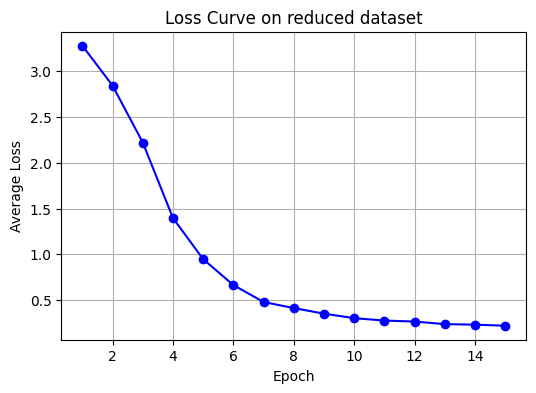

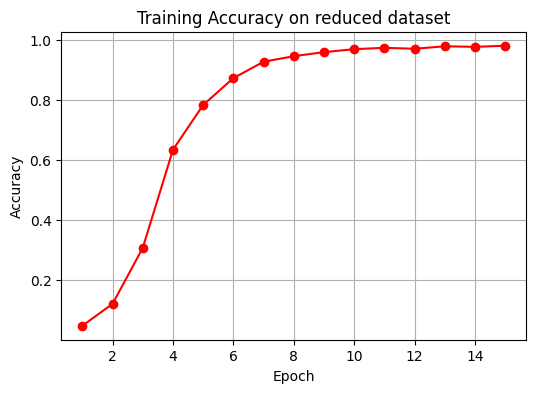

In [461]:
# Plot training loss
plt.figure(figsize=(6, 4))
plt.plot(range(1, len(train_losses) + 1), train_losses, 'b-', marker='o')
plt.title('Loss Curve on reduced dataset')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.grid(True)
plt.show()

# Plot training accuracy
plt.figure(figsize=(6, 4))
plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, 'r-', marker='o')
plt.title('Training Accuracy on reduced dataset')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

_______________________________________________________________________
**Q3: Report on Model Use**

#### Technical Approach:

**Person and relation extraction:**

We use regular patterns to identify relation type (birth_date, spouse, etc.). Originally, this seem to works but it sometime does not catch name or select non-important words. Based on the suggested note, we use NLTK package to filtering out unimportant words using stopwords. And use the tokenize and taging from NLTK to distinguish noun, verb and name. NLTK seem to capture the person name better.
For relation itentification, we still rely on regex and acknowledge that the patterns are limited on what we defined, it will not generalize well on unknown patterns.

We use multiple differnt max_keys aka introduce different numbers of distractors, wrong answer to the test to see how the model handle. Because the model was trained with 30 max_keys, it seem to handle question with 30 or less distractors. With higher distractor like over 100, the model structure, which is understandable. There is certain level of generalization achieve here as the model can handle slighly higher max_keys numbers.

**Results**
Please refer to part E for our test case. Our extraction method seem doing good enough. The model is able to capture name and relation correctly if it is simple and obvious. With harder or complex sentence, it will struggle.
For example it cannot capture complex name or name that include different pattern like alexander-hamilton. It have hard time capture non-English name like Ma Lik. This makes sense because our model is trained in English vocabulary.
For rare relation, like religion, it also struggle with correct answer.
For common relation like bio info that almost everyone has in the data like birth_date, birth_place, etc. it generally do well. In fact, even when increase max_keys to make it more challenging, it can still select the correct answer indicating certain level of generalization achieved.

**Limitation**
Overall, our model achieve 'not too bad' performance, but it clearly could been improved. First is we can extend our vocabulary and training on full dataset instead of reduced one.
Improve the person and relation extractor to better capture relevant and important information from the question/querry.
When creating question for training process, we could introduce more complex question and diverse question formats. The current one is too simple.
In training process, we can try to alleviate position bias by swap the correct answer position.





